# VOLATILITY IN STOCK MARKET INDICES
## Introduction to Programming and Numerical Analysis - Spring 2020 - Project 1: Data analysis

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `dataproject.py` file includes a function which will be used multiple times in this notebook.

**Imports and set magics:**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2 # install with pip install matplotlib-venn
plt.style.use('seaborn-whitegrid')

import pandas_datareader
import pydst #install with pip install pydst
import datetime
import quandl #install with pip install quandl

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
#import dataproject

# Read and clean data for stock market indices
In this section, we first import data for the Nasdaq Composite and Nikkei 225 indices using the FRED API, and OMX C20 data using the Qandl API. Because the Quandl time series only stretches back to early 2008 (when Nasdaq bought Københavns Fondsbørs), we complement the series with additional data from Statistics Denmark. 

Next, we clean and merge the datasets into a single Dataframe to be used for later analysis.

## FRED Data

In [2]:
# set start and end dates
start = datetime.datetime(2000,1,1)
end = datetime.datetime(2020,3,26)

# read in data
stock_indices = pandas_datareader.data.DataReader(['NASDAQCOM', 'NIKKEI225'], 'fred', start, end)

# rename columns and show head
stock_indices.rename(columns = {'NASDAQCOM':'nasdaq','NIKKEI225':'nikkei'}, inplace=True)

# reset index
stock_indices.reset_index(inplace=True)

stock_indices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5279 entries, 0 to 5278
Data columns (total 3 columns):
DATE      5279 non-null datetime64[ns]
nasdaq    5091 non-null float64
nikkei    4959 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 123.9 KB


In [3]:
# extract year from datetime variable
stock_indices['string_date'] = stock_indices['DATE'].astype(str)
stock_indices['year'] = stock_indices.string_date.str[:4]
stock_indices.drop('string_date',axis=1,inplace=True)
stock_indices.head(5)

,DATE,nasdaq,nikkei,year
0,2000-01-03,4131.15,NaN,2000
1,2000-01-04,3901.69,19002.86,2000
2,2000-01-05,3877.54,18542.55,2000
3,2000-01-06,3727.13,18168.27,2000
4,2000-01-07,3882.62,18193.41,2000


## Statistics Denmark Data

In [4]:
# setup data loader with the langauge 'english'
Dst = pydst.Dst(lang='en') 
tables = Dst.get_tables(subjects=['16'])
tables.head(10)

,id,text,unit,updated,firstPeriod,latestPeriod,active,variables
0,DNVPDKS,VP-registered securities,m DKK,2020-03-27 08:00:00,1999M12,2020M02,True,"[type of security, coupon, currency, maturity,..."
1,DNVPDKR,VP-registered securities,m DKK,2020-03-27 08:00:00,1999M12,2020M02,True,"[type of security, coupon, currency, maturity,..."
2,DNVPDKU,VP-registered securities,DKK mio.,2020-03-27 08:00:00,1999M12,2020M02,True,"[type of security, issuer sector, time]"
3,DNVPDKF,VP-registered securities by ISIN codes,m DKK,2020-03-27 08:00:00,2005M01,2020M02,True,"[ISIN_NAME, investor sector, time]"
4,DNVPDKBR,VP-registered securities,m DKK,2020-03-27 08:00:00,2008M11,2020M02,True,"[type of security, currency, issuer industry, ..."
5,DNVPEJER,Investor concentration in Danish mortgage-cred...,concentration index,2020-03-27 08:00:00,2005M01,2020M02,True,"[ISIN, time]"
6,DNVPSTRS,Structured bonds by characteristics,DKK mio.,2020-03-27 08:00:00,1999M12,2020M02,True,"[underlying asset type, option properties, pri..."
7,DNVPSTRH,Structured bonds by underlying asset types and...,DKK mio.,2020-03-27 08:00:00,1999M12,2020M02,True,"[underlying asset type, investor sector, valua..."
8,DNRENTD,Interest rates,per cent,2020-03-27 08:00:00,1983M05D10,2020M03D26,True,"[item, country, methodology, time]"
9,DNRENTM,Interest rates,-,2020-03-03 08:00:00,1985M10,2020M02,True,"[item, country, methodology, time]"


In [5]:
# inspect the table DNRENTD
tables[tables.id == 'DNRENTD']

,id,text,unit,updated,firstPeriod,latestPeriod,active,variables
8,DNRENTD,Interest rates,per cent,2020-03-27 08:00:00,1983M05D10,2020M03D26,True,"[item, country, methodology, time]"


In [6]:
# inspect variables of DNRENTD
omx_info = Dst.get_variables(table_id='DNRENTD')
omx_info

,id,text,elimination,time,values
0,INSTRUMENT,item,False,False,"[{'id': 'ODKNAA', 'text': 'The Nationalbanks o..."
1,LAND,country,True,False,"[{'id': 'DK', 'text': 'DK: Denmark'}]"
2,OPGOER,methodology,False,False,"[{'id': 'E', 'text': 'Daily interest rates (pe..."
3,Tid,time,False,True,"[{'id': '1983M05D10', 'text': '1983M05D10'}, {..."


In [21]:
# Print full string to find the key for OMX C20
#pd.set_option('display.max_colwidth', -1);
print(omx_info.loc[omx_info['id'] == 'INSTRUMENT'], ['values'])

           id  text  elimination   time  \
0  INSTRUMENT  item  False        False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [8]:
# read in data
omx_api = Dst.get_data(table_id = 'DNRENTD', variables={'INSTRUMENT':['CKXNAA'], 'LAND':['DK'], 'OPGOER':['I'], 'TID':['*']})

omx_api.head()

,INSTRUMENT,LAND,OPGOER,TID,INDHOLD
0,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1985M11D08,..
1,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1985M11D11,..
2,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1986M06D02,..
3,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1986M06D03,..
4,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1986M06D04,..


In [9]:
# rename column
omx_api.rename(columns = {'INDHOLD':'omx_c20'}, inplace=True)

# fix date format
omx_api['date'] = omx_api.TID.str[:4]+'-'+omx_api.TID.str[5:7]+'-'+omx_api.TID.str[-2:]
omx_api['date'] = pd.to_datetime(omx_api['date'])

# sort by 'date'
omx_api = omx_api.sort_values(['date'])

# drop missing values and reset index
omx_api = omx_api[omx_api['omx_c20'] != '..']
omx_api.reset_index(inplace=True)
omx_api.head()

,index,INSTRUMENT,LAND,OPGOER,TID,omx_c20,date
0,7911,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1994M01D03,109.1900,1994-01-03
1,657,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1994M01D04,109.8500,1994-01-04
2,658,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1994M01D05,110.1700,1994-01-05
3,659,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1994M01D06,109.7900,1994-01-06
4,660,OMXC20 share price index (prev. KFX) (3 July 1...,DK: Denmark,Index,1994M01D07,109.0600,1994-01-07


In [10]:
# drop irrelevant columns
drop_these = ['index', 'INSTRUMENT', 'LAND', 'OPGOER', 'index','TID']
omx_api.drop(drop_these, axis=1, inplace=True)
omx_api

,omx_c20,date
0,109.1900,1994-01-03
1,109.8500,1994-01-04
2,110.1700,1994-01-05
3,109.7900,1994-01-06
4,109.0600,1994-01-07
...,...,...
4744,487.2200,2012-11-26
4745,488.8800,2012-11-27
4746,486.4400,2012-11-28
4747,490.7700,2012-11-29


In [11]:
# drop dates before y2k and after NASDAQ aquisition

# a) find index of last trading day before y2k
omx_api.loc[omx_api['date'] == '1999-12-31']

# b) slice df
omx_api = omx_api.iloc[1510:]
omx_api.head(5)

,omx_c20,date
1510,260.9200,2000-01-03
1511,252.7800,2000-01-04
1512,246.9800,2000-01-05
1513,249.4700,2000-01-06
1514,251.7900,2000-01-07


## Quandl Data

In [12]:
omx_qua = quandl.get('NASDAQOMX/OMXC20')
drop_them = ['High', 'Low', 'Total Market Value', 'Dividend Market Value']
omx_qua.drop(drop_them,axis=1,inplace=True)
omx_qua.rename(columns={'Index Value':'omx_c20'},inplace=True)
omx_qua

,omx_c20
Trade Date,
2008-11-17,262.89
2008-11-18,259.09
2008-11-19,249.53
2008-11-20,236.79
2008-11-24,245.91
...,...
2020-03-23,939.76
2020-03-24,969.53
2020-03-25,993.08


### Merge Quandl and Statistics Denmark data with outer join

## Merge Data sets

## Explore data set

In order to be able to **explore the raw data**, we here provide an **interactive plot** to show, respectively, the employment and income level in each municipality

The **static plot** is:

In [13]:
#def plot_empl_inc(empl,inc,dataset,municipality): 
    
#    if dataset == 'Employment':
#        df = empl
#        y = 'employment'
 #   else:
  #      df = inc
   #     y = 'income'
    
   # I = df['municipality'] == municipality
   # ax = df.loc[I,:].plot(x='year', y=y, style='-o')

The **interactive plot** is:

In [15]:
#widgets.interact(plot_empl_inc, 
    
#    empl = widgets.fixed(empl_long),
 #   inc = widgets.fixed(inc_long),
  #  dataset = widgets.Dropdown(description='Dataset', 
 #                              options=['Employment','Income']),
   # municipality = widgets.Dropdown(description='Municipality', 
#                                    options=empl_long.municipality.unique())
                 
#); 

ADD SOMETHING HERE IF THE READER SHOULD KNOW THAT E.G. SOME MUNICIPALITY IS SPECIAL.

# Merge data sets

We now create a data set with **municpalities which are in both of our data sets**. We can illustrate this **merge** as:

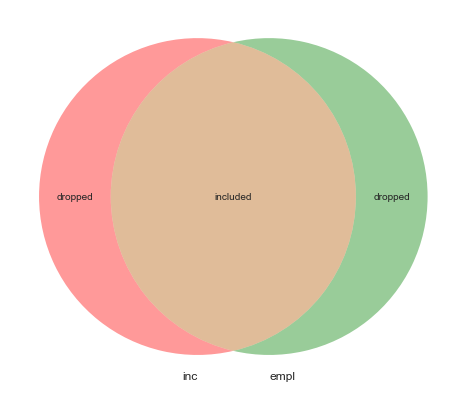

In [16]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('inc', 'empl'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

In [17]:
merged = pd.merge(empl_long, inc_long, how='inner',on=['municipality','year'])

print(f'Number of municipalities = {len(merged.municipality.unique())}')
print(f'Number of years          = {len(merged.year.unique())}')

NameError: name 'empl_long' is not defined

# Analysis

To be able to make comparisons between the indices, we calculate the log returns as follows: 

1. Calculate log returns
2. Summary statistics (mean, std. dev./variance, group by year/month(sell in May...)/country). Both numbers and graphs.
3. Volatility plots, rolling std.dev. Compare corona crisis with financial crisis and dotcom bubble. 

To get a quick overview of the data, we show some **summary statistics by year**:

## Summary Statistics

In [18]:
#calculate log returns
indices = ['nasdaq','nikkei']
for i in indices:
    stock_indices[f'log_returns_{i}']= np.log(stock_indices[i]).diff()*100

In [19]:
# create DataFrame with descriptive stats by year

# setup empty dataframe
desc_stat=pd.DataFrame()

# append columns to desc_stat
for i in indices:
    desc_stat[f'mean_{i}']= stock_indices.groupby('year')[f'log_returns_{i}'].mean()
    desc_stat[f'std_{i}'] = stock_indices.groupby('year')[f'log_returns_{i}'].std()
    desc_stat[f'min_{i}'] = stock_indices.groupby('year')[f'log_returns_{i}'].min()
    desc_stat[f'max_{i}'] = stock_indices.groupby('year')[f'log_returns_{i}'].max()

desc_stat

,mean_nasdaq,std_nasdaq,min_nasdaq,max_nasdaq,mean_nikkei,std_nikkei,min_nikkei,max_nikkei
year,,,,,,,,
2000,-0.223634,3.040178,-10.168411,9.963643,-0.144391,1.413980,-7.233984,3.688680
2001,0.018251,2.662478,-6.511092,13.254645,-0.145368,1.778012,-6.864457,4.785591
2002,-0.140102,2.148023,-4.268674,7.493773,-0.121180,1.584970,-4.104463,5.735232
2003,0.108891,1.363760,-3.730166,4.697792,0.010400,1.429745,-5.225837,3.325562
2004,0.036612,1.071422,-2.552371,2.976501,0.049882,1.128903,-4.965470,2.764005
2005,0.003338,0.784713,-2.079413,2.510342,0.096282,0.837941,-3.875580,2.206586
2006,0.051367,0.880156,-2.378830,2.918396,0.044059,1.249234,-4.230414,3.522034
2007,0.019013,1.110136,-3.935871,3.405569,-0.084207,1.163116,-5.569546,3.603123
2008,-0.212372,2.616212,-9.587690,11.159442,-0.322277,2.787078,-12.111026,9.494147


ADD FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

## Volatility plots

/Users/Christian/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


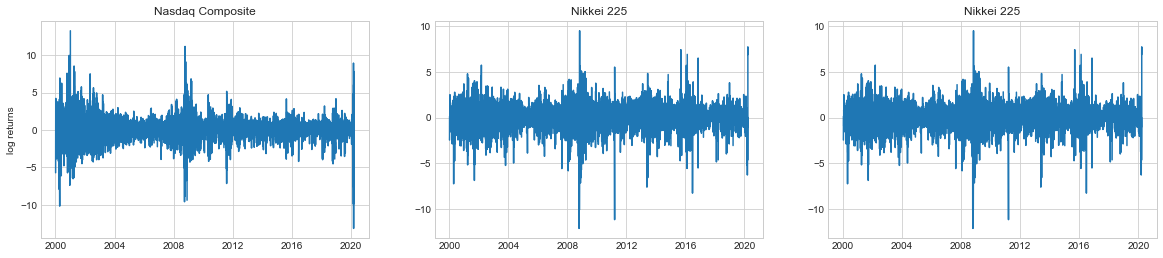

In [20]:
# a. create the figure
fig = plt.figure(figsize=(20,4))

ax_left = fig.add_subplot(1,3,1)

ax_left.plot(stock_indices.DATE,stock_indices.log_returns_nasdaq)
ax_left.set_title('Nasdaq Composite')
ax_left.set_ylabel('log returns')
ax_left.grid(True)

ax_mid = fig.add_subplot(1,3,2)

ax_mid.plot(stock_indices.DATE,stock_indices.log_returns_nikkei)
ax_mid.set_title('Nikkei 225')
ax_mid.grid(True)
            
ax_right = fig.add_subplot(1,3,3)

ax_right.plot(stock_indices.DATE,stock_indices.log_returns_nikkei)
ax_right.set_title('Nikkei 225')
ax_right.grid(True)

# Conclusion

ADD CONCISE CONLUSION.